# Pneumonia Detection in Chest X-Ray Images

## Set up

In [1]:
!pip install tensorflow --upgrade

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, plot_roc_curve, plot_confusion_matrix
import pathlib
import os, warnings

#!pip install pyradiomics
#import radiomics

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

%matplotlib inline

def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(190121)

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")

train_path = '../input/chest-xray-pneumonia/chest_xray/train'
test_path = '../input/chest-xray-pneumonia/chest_xray/test'
valid_path = '../input/chest-xray-pneumonia/chest_xray/val'

     |████████████████████████████████| 489.6 MB 17 kB/s 
     |████████████████████████████████| 1.3 MB 61.7 MB/s 
     |████████████████████████████████| 13.3 MB 51.4 MB/s 
     |████████████████████████████████| 5.8 MB 36.0 MB/s 
     |████████████████████████████████| 4.9 MB 59.9 MB/s 
     |████████████████████████████████| 463 kB 38.6 MB/s 
     |████████████████████████████████| 2.1 MB 62.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
  Attempting uninstall: tensorflow
    Found existing installatio

## Exploratory Data Analysis

https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

### Image Visualization

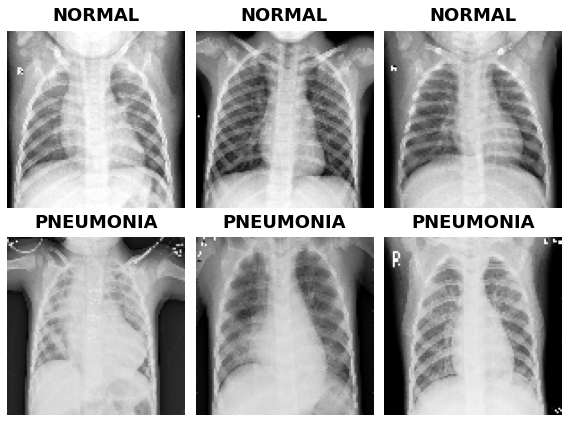

(1341, 3875)

In [2]:
normal_imgs = [x for x in os.listdir(f'{train_path}/NORMAL') if x.endswith('.jpeg')]
pneumo_imgs = [y for y in os.listdir(f'{train_path}/PNEUMONIA') if y.endswith('.jpeg')]

select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)

fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_path}/NORMAL/{select_norm[i]}'
        label = 'NORMAL'
    else:
        fp = f'{train_path}/PNEUMONIA/{select_pneu[i-3]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 3, i+1)
    
    fn = tf.keras.preprocessing.image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

len(normal_imgs), len(pneumo_imgs)

### Images to Numpy Array

In [3]:
size = (64, 64)

def imgs2np(path, file_list, size = (64, 64)):
    
    for i in file_list:
        image_path = path + i
        image = tf.keras.preprocessing.image.load_img(image_path, target_size = size, color_mode='grayscale')
        image = tf.keras.preprocessing.image.img_to_array(image)
        img_ts = [image.ravel()]
        
        try:
            np_array = np.concatenate((np_array, img_ts))

        except NameError:
            np_array = img_ts    

    return np_array

np_normal_images = imgs2np(f'{train_path}/NORMAL/', normal_imgs)
np_pneumonia_images = imgs2np(f'{train_path}/PNEUMONIA/', pneumo_imgs)

## Images Averaging

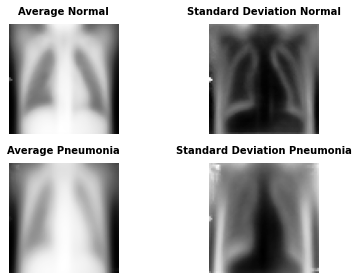

In [4]:
mean_img_norm = np.mean(np_normal_images, axis=0).reshape(size)
mean_img_pneum = np.mean(np_pneumonia_images, axis=0).reshape(size)
std_img_norm = np.std(np_normal_images, axis=0).reshape(size)
std_img_pneum = np.std(np_pneumonia_images, axis=0).reshape(size)

ax = plt.subplot(2, 2, 1)
plt.imshow(mean_img_norm, cmap='Greys_r')
plt.title('Average Normal', fontsize=10)
plt.axis('off')

ax = plt.subplot(2, 2, 2)
plt.imshow(std_img_norm, cmap='Greys_r')
plt.title('Standard Deviation Normal', fontsize=10)
plt.axis('off')

ax = plt.subplot(2, 2, 3)
plt.imshow(mean_img_pneum, cmap='Greys_r')
plt.title('Average Pneumonia', fontsize=10)
plt.axis('off')

ax = plt.subplot(2, 2, 4)
plt.imshow(std_img_pneum, cmap='Greys_r')
plt.title('Standard Deviation Pneumonia', fontsize=10)
plt.axis('off')

plt.show()

## Contrast Between Images

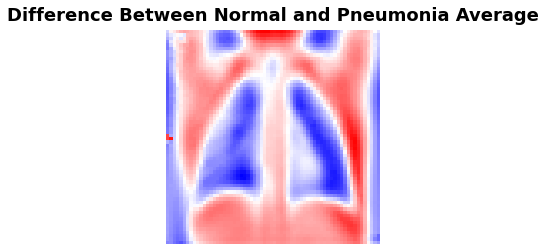

In [5]:
contrast_mean = mean_img_norm - mean_img_pneum
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal and Pneumonia Average')
plt.axis('off')
plt.show()

## Eigenimages

Number of PC:  28


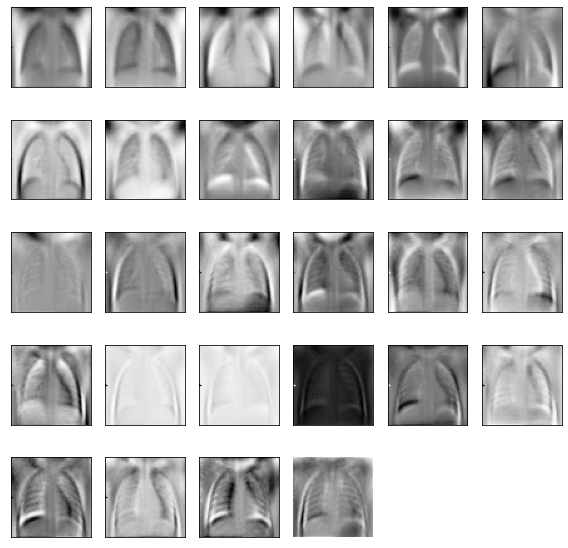

Number of PC:  14


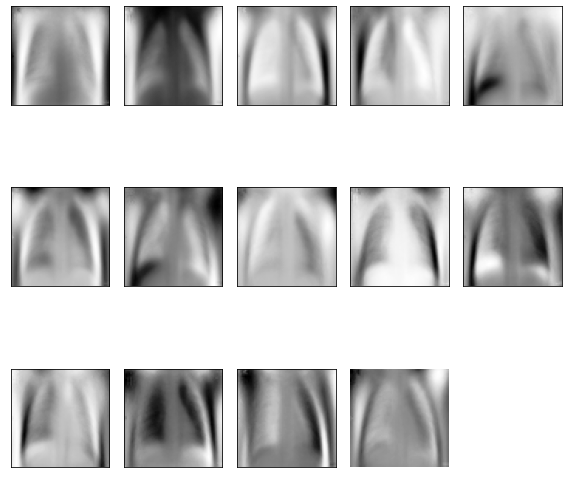

In [6]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(np_normal_images, 'NORMAL'))
plot_pca(eigenimages(np_pneumonia_images, 'PNEUMONIA'))

## Loading datasets as TensorFlow objects

In [7]:
ds_train = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='binary',
    image_size=(224,224),
    batch_size=32,
    shuffle=True,
)

ds_test = image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='binary',
    image_size=(224,224),
    batch_size=32,
    shuffle=False,
)

ds_valid = image_dataset_from_directory(
    valid_path,
    labels='inferred',
    label_mode='binary',
    image_size=(224,224),
    batch_size=32,
    shuffle=True,
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [8]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = ds_train.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
ds_valid = ds_valid.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)

## Transfer learning

In [10]:
"""
pretrained_base = tf.keras.applications.vgg16.VGG16()
pretrained_base.trainable = False

model = tf.keras.models.Sequential([
    pretrained_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
pretrained_base.summary()
"""

"\npretrained_base = tf.keras.applications.vgg16.VGG16()\npretrained_base.trainable = False\n\nmodel = tf.keras.models.Sequential([\n    pretrained_base,\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dense(10, activation='relu'),\n    tf.keras.layers.Dense(1, activation='sigmoid')\n])\n\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])\npretrained_base.summary()\n"

In [11]:
# history = model.fit(ds_train, validation_data=ds_test,epochs=50, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True))

In [12]:
# model.summary()

In [13]:
"""

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

"""

"\n\nhistory_frame = pd.DataFrame(history.history)\nhistory_frame.loc[:, ['loss', 'val_loss']].plot()\nhistory_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()\n\n"

## Custom Convolutional Neural Network

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomContrast(0.5),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [15]:
history = model.fit(ds_train, validation_data=ds_test,epochs=50, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True))

Epoch 1/50
163/163 [==============================] - 688s 4s/step - loss: 3.8094 - binary_accuracy: 0.7412 - val_loss: 0.6802 - val_binary_accuracy: 0.6250
Epoch 2/50
163/163 [==============================] - 674s 4s/step - loss: 0.6523 - binary_accuracy: 0.7429 - val_loss: 0.6693 - val_binary_accuracy: 0.6250
Epoch 3/50
163/163 [==============================] - 674s 4s/step - loss: 0.6285 - binary_accuracy: 0.7429 - val_loss: 0.6636 - val_binary_accuracy: 0.6250
Epoch 4/50
163/163 [==============================] - 671s 4s/step - loss: 0.6108 - binary_accuracy: 0.7429 - val_loss: 0.6616 - val_binary_accuracy: 0.6250
Epoch 5/50
163/163 [==============================] - 677s 4s/step - loss: 0.5980 - binary_accuracy: 0.7429 - val_loss: 0.6623 - val_binary_accuracy: 0.6250
Epoch 6/50
163/163 [==============================] - 678s 4s/step - loss: 0.5888 - binary_accuracy: 0.7429 - val_loss: 0.6647 - val_binary_accuracy: 0.6250
Epoch 7/50
163/163 [==============================] - 684s

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0

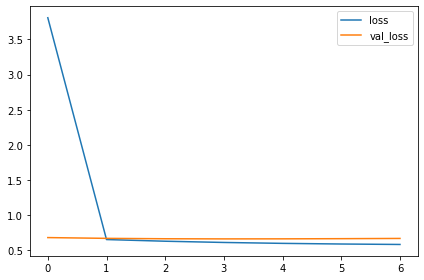

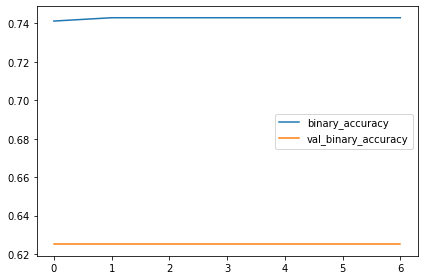

In [17]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [18]:
#model.save('./model1')